<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/Build_an_Efficient_TensorFlow_Input_Pipeline_for_Char_Level_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# PREPARATION

In [43]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

In [44]:
tf.__version__

'2.4.1'

In [45]:
#pip install --upgrade tensorflow

In [46]:
#drive.mount("/gdrive", force_remount=True)

In [47]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive/MyDrive/'Colab Notebooks'/
#%ls

In [48]:
def save_dataset(dataset,fileName):
  path = os.path.join('./tfDatasets/', fileName)
  tf.data.experimental.save(dataset, path)

def load_dataset(fileName):
  path = os.path.join("./tfDatasets/", fileName)
  new_dataset = tf.data.experimental.load(path,
      tf.TensorSpec(shape=(), dtype=tf.string))
  return new_dataset

---
# Building an Efficient TensorFlow Input Pipeline  for Character-Level Text Generation


This tutorial is the second part of the "**Text Generation in Deep Learning with Tensorflow & Keras**" series.

In this series, we have been covering all the  topics related to Text Generation with sample implementations in **Python**.

In this tutorial, we will focus on how to **build an Efficient TensorFlow Input Pipeline for Character-Level Text Generation**.

**First**, we will download a sample  corpus (text file). 

**After** opening the file and reading it line-by-line, we will convert it to a single line of text. 

**Then**, we will split the text into input character sequence (X) and output character (y).

**Using** tf.data API and Keras TextVectorization methods, we will 
* preprocess the text, 
* convert the characters into integer representation, 
* prepare the training dataset,
* optimize the data pipeline.

Thus, **in the end**, we will be ready to train a Language Model for character-level text generation.


If you would like to learn more about **Deep Learning** with practical coding examples, please subscribe to [Murat Karakaya Akademi YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA)  or follow [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **notifications** so that you will be notified when new parts are uploaded.

You can access this **Colab Notebook** using the link given in the video description below.

If you are ready, let's get started!



## [Text Generation in Deep Learning with Tensorflow & Keras Series:](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1)

**Part A**: Fundamentals 

**Part B**: ***Tensorflow Data Pipeline for Character Level Text Generation***

**Part C**: Tensorflow Data Pipeline for Word Level Text Generation

**Part D**: Recurrent Neural Network (LSTM) Model for Character Level Text Generation

**Part E**: Encoder-Decoder Model for Character Level Text Generation

**Part F**: Recurrent Neural Network (LSTM) Model for Word Level Text Generation

**Part G**: Encoder-Decoder Model for Word Level Text Generation


You can **watch** all these parts on [Murat Karakaya Akademi channel on YouTube](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA) in **[ENGLISH](https://youtube.com/playlist?list=PLQflnv_s49v9QOres0xwKyu21Ai-Gi3Eu)** or **[TURKISH](https://youtube.com/playlist?list=PLQflnv_s49v-oEYNgoqK5e4GyUbodfET3)**

I **assume** that ***you have already watched all previous parts***.
Please ensure that you have reviewed the previous parts in order to utilize this part better.



## References

[What is a Data Pipeline?](https://www.alooma.com/blog/what-is-a-data-pipeline)


[tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)


[Text classification from scratch](https://keras.io/examples/nlp/text_classification_from_scratch/)

[Working with Keras preprocessing layers](https://keras.io/guides/preprocessing_layers/)

[Character-level text generation with LSTM](https://keras.io/examples/generative/lstm_character_level_text_generation/)

[Character-level text generation with LSTM](https://keras.io/examples/generative/lstm_character_level_text_generation/)

[Toward Controlled Generation of Text](https://arxiv.org/abs/1703.00955)

[Attention Is All You Need](https://arxiv.org/abs/1706.03762)

[Talk to Transformer](https://app.inferkit.com/demo)

[What is the difference between word-based and char-based text generation RNNs?](https://datascience.stackexchange.com/questions/13138/what-is-the-difference-between-word-based-and-char-based-text-generation-rnns)

[The survey: Text generation models in deep learning](https://www.sciencedirect.com/science/article/pii/S1319157820303360)

[Generative Adversarial Networks for Text Generation](https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-1-2b886c8cab10)

[FGGAN: Feature-Guiding Generative Adversarial Networks for Text Generation](https://ieeexplore.ieee.org/abstract/document/9091179)

[How to sample from language models](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277)

[How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)

[Hierarchical Neural Story Generation](https://arxiv.org/abs/1805.04833)

In [49]:
#@title 
from IPython.display import HTML

# Youtube
HTML('<iframe width="400" height="300" src="https://www.youtube.com/embed/E_kpn3QjGNw?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

# What is a Character Level Text Generation?
A **Language Model** can be trained to generate text **character-by-character**. In this case, each of the **input** and **output** tokens is a **character**. Moreover, Language Model outputs **a conditional probability distribution** over **character set**.

For more details, please check [Part A.](https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e)

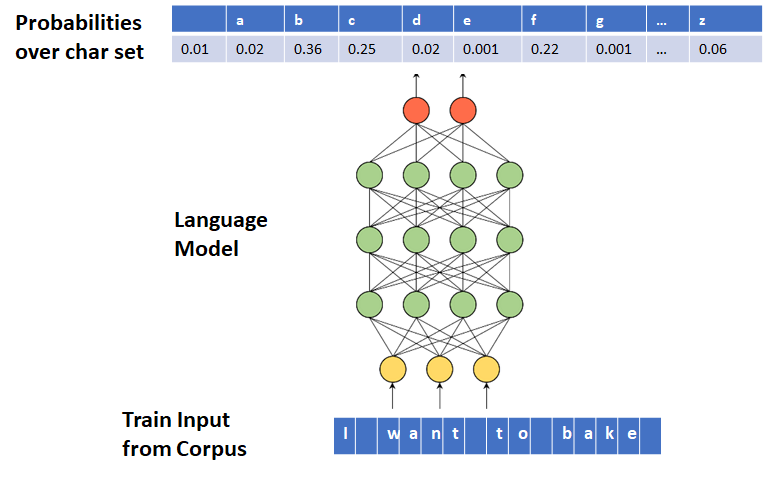

---
# Tensorflow Data Pipeline: tf.data

## What is a Data Pipeline?

Data Pipeline is an **automated** process that involves in **extracting**, **transforming**, **combining**, **validating**, and **loading** data for further analysis and visualization. 

It provides **end-to-end** velocity by ***eliminating*** errors and ***combatting*** bottlenecks or latency. 

It can process **multiple** data streams at once. 

In short, it is an **absolute necessity** for today’s data-driven solutions.

If you are **not familiar** with data pipelines, you can check my tutorials in [English](https://youtube.com/playlist?list=PLQflnv_s49v_m6KLMsORgs9hVIvDCwDAb) or [Turkish](https://youtube.com/playlist?list=PLQflnv_s49v8l8dYU01150vcoAn4sWSAm).


## Why Tensorflow Data Pipeline?

The **tf.data** API enables us 
* to build **complex** input pipelines from simple, reusable pieces. 

* to handle **large amounts of data**, read from **different data formats**, and perform **complex transformations**.




## What can be done in a Text Data Pipeline?

The pipeline for a text model might involve **extracting symbols** from raw text data, **converting** them to embedding identifiers with a lookup table, and **batching** together sequences of different lengths. 

## What will we do in this Text Data pipeline?

We will create a data pipeline to **prepare training data for character-level text generator**.

Thus, in the pipeline, we will
* **open** & **load** corpus (text file)
* **convert** the text into sequence of characters
* **remove** unwanted characters such as punctuations, HTML tags, white spaces, etc.
* **generate** input (X) and output (y) pairs as character sequences
* **concatenate** input (X) and output (y) into train data
* **cache, prefetch, and batch** the train data for performance





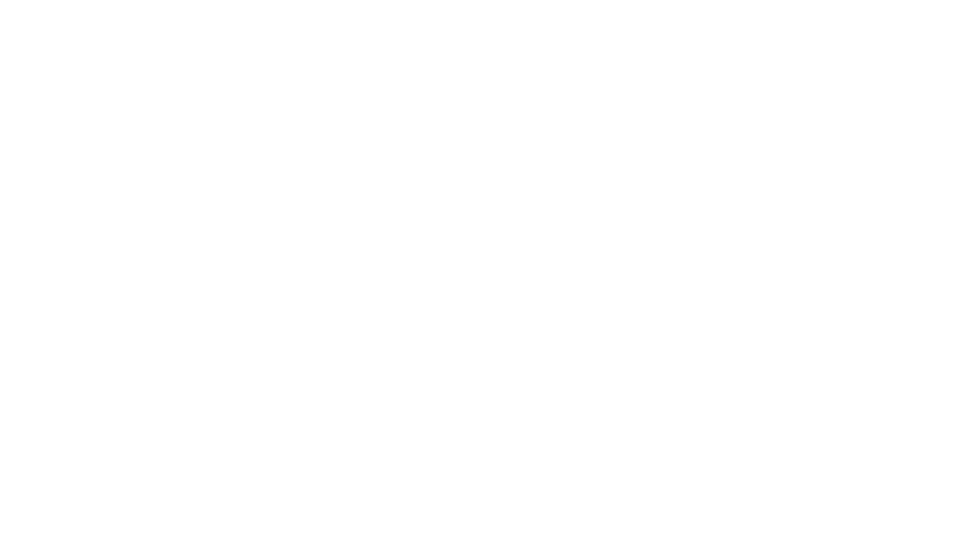

After, this brief introduction to the Tensorflow Data pipeline, let's start creating our text pipeline.

---
# Building an Efficient TensorFlow Input Pipeline  for Character-Level Text Generation

---
# 1. DOWNLOAD DATA


In [50]:
#!curl -O https://s3.amazonaws.com/text-datasets/nietzsche.txt

In [51]:
!curl -O https://raw.githubusercontent.com/kmkarakaya/ML_tutorials/master/data/mesnevi_Tumu.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2586k  100 2586k    0     0  11.6M      0 --:--:-- --:--:-- --:--:-- 11.6M


---
# 2. LOAD TEXT DATA LINE BY LINE

To load the data into our pipeline, I will use `tf.data.TextLineDataset()` method.

In [52]:
batch_size = 64
#raw_data_ds = tf.data.TextLineDataset(["nietzsche.txt"])
raw_data_ds = tf.data.TextLineDataset(["mesnevi_Tumu.txt"])

Let's see some lines from the uploaded text:

In [53]:
for elems in raw_data_ds.take(10):
    print(elems.numpy().decode("utf-8"))

1. Dinle, bu ney nasıl şikâyet ediyor, ayrılıkları nasıl anlatıyor:
Beni kamışlıktan kestiklerinden beri feryadımdan erkek, kadın… herkes ağlayıp inledi.
Ayrılıktan parça parça olmuş, kalb isterim ki, iştiyak derdini açayım.
Aslında uzak düşen kişi, yine vuslat zamanını arar.

5. Ben her cemiyette ağladım, inledim. Fena hallilerle de eş oldum, iyi hallilerle de.
Herkes kendi zannınca benim dostum oldu ama kimse içimdeki sırları araştırmadı.
Benim esrarım feryadımdan uzak değildir, ancak (her) gözde, kulakta o nur yok.
Ten candan, can da tenden gizli kapaklı değildir, lâkin canı görmek için kimseye izin yok.
Bu neyin sesi ateştir, hava değil; kimde bu ateş yoksa yok olsun!


---
# 3. COMBINE ALL LINES INTO A SINGLE TEXT 

Since our aim is to prepare a train dataset for a **character-level** text generator, we need to **convert the line-by-line text into char-by-char text**. 

Therefore, we first combine all line-by-line text as **a single text**:

In [54]:
text=""
for elem in raw_data_ds:
   text=text+(elem.numpy().decode('utf-8'))
splitted=tf.strings.bytes_split(text)

print(text[:1000])

1. Dinle, bu ney nasıl şikâyet ediyor, ayrılıkları nasıl anlatıyor:Beni kamışlıktan kestiklerinden beri feryadımdan erkek, kadın… herkes ağlayıp inledi.Ayrılıktan parça parça olmuş, kalb isterim ki, iştiyak derdini açayım.Aslında uzak düşen kişi, yine vuslat zamanını arar.5. Ben her cemiyette ağladım, inledim. Fena hallilerle de eş oldum, iyi hallilerle de.Herkes kendi zannınca benim dostum oldu ama kimse içimdeki sırları araştırmadı.Benim esrarım feryadımdan uzak değildir, ancak (her) gözde, kulakta o nur yok.Ten candan, can da tenden gizli kapaklı değildir, lâkin canı görmek için kimseye izin yok.Bu neyin sesi ateştir, hava değil; kimde bu ateş yoksa yok olsun!10. Aşk ateşidir ki neyin içine düşmüştür, aşk coşkunluğudur ki şarabın içine düşmüştür.Ney, dosttan ayrılan kişinin arkadaşı, haldaşıdır. Onun perdeleri, perdelerimizi yırttı.Ney gibi hem bir zehir, hem bir tiryak, ney gibi hem bir hemdem, hem bir müştak kim gördü?Ney, kanla dolu olan yoldan bahsetmekte, Mecnun aşkının kıssala

---
# 4. SPLIT THE TEXT INTO TOKENS

**[In Part A](https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e)**, we mentioned that we can train a language model and generate new text by using two different units:
* character level
* word level

That is, you can split your text into sequence of characters or words.

In this tutorial, we will focus on **character level** tokenization. 

If you would like to learn how to create **word level** tokenization please take a look at **[Part C](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1)**.



## Check the size of the corpus

[In his post](https://keras.io/examples/generative/lstm_character_level_text_generation/), François Chollet suggested that "....***make sure your corpus has at least ~100k characters. ~1M is better***" to see if it suits to text generation.

Let's see the size of our corpus in chars:

In [55]:
print("Corpus length:", int(len(text)/1000),"K chars")

Corpus length: 2336 K chars


It looks like that the corpus big enough. 

## Check the number of distinct characters

In [56]:
chars = sorted(list(set(text)))
print("Total disctinct chars:", len(chars))

Total disctinct chars: 96


## Set the split parameters

We can split the text into two sets of **fixed-size char sequences** as below:
* The first sequence (**`input_chars`**) is  the **input data** (X) to the model which will receive a fixed-size (**`maxlen`**) character sequence 
* The second sequence (**`next_char`**) is  the **output data** (y) to the model which is only  1 char 

While creating these sequences, we can jump over the data by setting **`step`** to a fixed character number.

We define all these parameters below:


In [57]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 20
step = 3
input_chars = []
next_char = []

Using the above parameters, we can split the text into **input (X)** and **output (y)** sequences:

In [58]:
for i in range(0, len(text) - maxlen, step):
    input_chars.append(text[i : i + maxlen])
    next_char.append(text[i + maxlen])

## Check the generated sequences
After splitting the text, we can check the number of sequences and see a sample input and output:

In [59]:
print("Number of sequences:", len(input_chars))
print("input X  (input_chars)  --->   output y (next_char) ")

for i in range(5):
  print( input_chars[i],"   --->  ", next_char[i])



Number of sequences: 778952
input X  (input_chars)  --->   output y (next_char) 
1. Dinle, bu ney nas    --->   ı
Dinle, bu ney nasıl     --->   ş
le, bu ney nasıl şik    --->   â
 bu ney nasıl şikâye    --->   t
 ney nasıl şikâyet e    --->   d


---
# 5. CREATE X & y DATASETS

We can use these two sequences to create **X and y datasets** by using **`tf.data.Dataset.from_tensor_slices()`** method:

In [60]:
X_train_ds_raw=tf.data.Dataset.from_tensor_slices(input_chars)
y_train_ds_raw=tf.data.Dataset.from_tensor_slices(next_char)

Let's see some input-output pairs:

In [61]:
for elem1, elem2 in zip(X_train_ds_raw.take(5),y_train_ds_raw.take(5)):
   print(elem1.numpy().decode('utf-8'),"----->", elem2.numpy().decode('utf-8'))

1. Dinle, bu ney nas -----> ı
Dinle, bu ney nasıl  -----> ş
le, bu ney nasıl şik -----> â
 bu ney nasıl şikâye -----> t
 ney nasıl şikâyet e -----> d


---
# 6. PREPROCESS THE TEXT

We need to process these datasets before feeding them into a model. 

Here, we will use the [Keras preprocessing layer "***TextVectorization***"](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization). 



## Why do we use Keras preprocessing layer?

**[Because](https://keras.io/guides/preprocessing_layers/)**:

* The Keras preprocessing layers API allows developers to build **Keras-native input processing pipelines**. These input processing pipelines can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and **exported as part of a Keras SavedModel**.

* With Keras preprocessing layers, we can ***build and export models*** that are **truly end-to-end**: models that ***accept raw images*** or ***raw structured data*** as input; models that handle ***feature normalization*** or ***feature value indexing*** on their own.

In the next part, we will create the end-to-end Text Generation model and we will see the benefits of using Keras preprocessing layers.


## What are the preprocessing steps?

The processing of each sample contains the following steps:

* **standardize** each sample (usually lowercasing + punctuation stripping): 

  In this tutorial, we will create a **custom standardization function** to show how to apply your code to strip un-wanted chars and symbols.

* **split** each sample into substrings (usually words):

  As in this part, we choose to split the text into **fixed-size character sequences**, we will write a **custom split function**

* **recombine** substrings into tokens (usually ngrams):
  We will leave it as 1 ngram (char)

* **index tokens** (associate a unique int value with each token)

* **transform** each sample using this index, either into a vector of ints or a dense float vector.

### Prepare custom *standardization* and *split* functions

* We have our **custom** ***standardization*** and ***split*** functions


In [62]:
def custom_standardization(input_data):
    lowercase     = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    stripped_num  = tf.strings.regex_replace(stripped_html, "[\d-]", " ")
    stripped_punc  =tf.strings.regex_replace(stripped_num, 
                             "[%s]" % re.escape(string.punctuation), "")    
    return stripped_punc

def char_split(input_data):
  return tf.strings.unicode_split(input_data, 'UTF-8')

def word_split(input_data):
  return tf.strings.split(input_data)

### Set the text vectorization parameters

* We can limit the number of distinct characters by setting `max_features`
* We set an explicit `sequence_length`, since our  model needs **fixed-size** input sequences.


In [63]:
# Model constants.
max_features = 96           # Number of distinct chars / words  
embedding_dim = 16             # Embedding layer output dimension
sequence_length = maxlen       # Input sequence size


### Create the text vectorization layer

* The **text vectorization layer** is initialized below. 
* We are using this layer to normalize, split, and map strings to integers, so we set our 'output_mode' to '**int**'.


In [64]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    split=char_split, # word_split or char_split
    output_mode="int",
    output_sequence_length=sequence_length,
)

### Adapt the Text Vectorization layer to the train dataset

Now that the **Text Vectorization layer** has been created, we can call `adapt` on a text-only dataset to create the vocabulary with indexing. 

You don't have to batch, but for very large datasets this means you're not keeping spare copies of the dataset in memory.

In [65]:
vectorize_layer.adapt(X_train_ds_raw.batch(batch_size))

We can take a look at the size of the vocabulary

In [66]:
print("The size of the vocabulary (number of distinct characters): ", len(vectorize_layer.get_vocabulary()))

The size of the vocabulary (number of distinct characters):  53


Let's see the first 5 entries in the vocabulary:

In [67]:
print("The first 10 entries: ", vectorize_layer.get_vocabulary()[:10])

The first 10 entries:  ['', '[UNK]', ' ', 'a', 'e', 'i', 'n', 'r', 'l', 'd']


You can access the vocabulary by using an index:

In [68]:
vectorize_layer.get_vocabulary()[3]

'a'

After preparing the **Text Vectorization layer**,  we need a helper function to **convert a given raw text to a Tensor** by using this layer:

In [69]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

A simple test of the function:

In [83]:
vectorize_text("Ne ister gönül?")

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 6,  4,  2,  5, 15, 13,  4,  7,  2, 23, 25,  6, 18,  8,  0,  0,  0,
        0,  0,  0])>

### Apply the **Text Vectorization** onto X and y datasets

In [71]:
# Vectorize the data.
X_train_ds = X_train_ds_raw.map(vectorize_text)
y_train_ds = y_train_ds_raw.map(vectorize_text)

X_train_ds.element_spec, y_train_ds.element_spec

(TensorSpec(shape=(20,), dtype=tf.int64, name=None),
 TensorSpec(shape=(20,), dtype=tf.int64, name=None))

### Convert **y** to a single char representation

In [72]:
y_train_ds=y_train_ds.map(lambda x: x[0])

In [73]:
for elem in y_train_ds.take(1):
  print("shape: ", elem.shape, "\n next_char: ",elem.numpy())

shape:  () 
 next_char:  10


### Check the tensor dimensions to ensure that we have max-sequence size inputs and a single output:

In [74]:
X_train_ds.take(1), y_train_ds.take(1)

(<TakeDataset shapes: (20,), types: tf.int64>,
 <TakeDataset shapes: (), types: tf.int64>)

### Let's see an example pair:

In [75]:
for (X,y) in zip(X_train_ds.take(5), y_train_ds.take(5)):
  print(X.numpy()," --> ",y.numpy())

[ 2  2  9  5  6  8  4  2 17 12  2  6  4 16  2  6  3 15  0  0]  -->  10
[ 9  5  6  8  4  2 17 12  2  6  4 16  2  6  3 15 10  8  2  0]  -->  20
[ 8  4  2 17 12  2  6  4 16  2  6  3 15 10  8  2 20  5 11  0]  -->  31
[ 2 17 12  2  6  4 16  2  6  3 15 10  8  2 20  5 11 31 16  4]  -->  13
[ 2  6  4 16  2  6  3 15 10  8  2 20  5 11 31 16  4 13  2  4]  -->  9


# 7. FINALIZE THE DATA PIPELINE

## Join the input (X) and output (y) values as a single dataset

In [76]:
train_ds =  tf.data.Dataset.zip((X_train_ds,y_train_ds))

## Set data pipeline optimizations
Do async prefetching / buffering of the data for best performance on GPU

In [77]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

## Check the size of the dataset (in batches):

In [78]:
print("The size of the dataset (in batches)): ", train_ds.cardinality().numpy())

The size of the dataset (in batches)):  12171


## Again, let's check the tensor dimensions of **input X** and **output y**:

In [79]:
for sample in train_ds.take(1):
  print("input (X) dimension: ", sample[0].numpy().shape, "\noutput (y) dimension: ",sample[1].numpy().shape)

input (X) dimension:  (64, 20) 
output (y) dimension:  (64,)


# CONCLUSION:
In this tutorial, we apply the following steps to create **Tensorflow Data Pipeline** for ***character level*** text generation:
* download a corpus
* split the text into characters
* vectorize the text by using the Keras preprocessing layer "**TextVectorization**"
* prepare input X and output y
* **optimize** the data pipelines by ***batching, prefetching, and caching***.

[In the next parts](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1), we will see 

* Part C: Tensorflow Data Pipeline for Word Level Text Generation

* Part D: Recurrent Neural Network (LSTM) Model for Character Level Text Generation

* Part E: Encoder-Decoder Model for Character Level Text Generation

* Part F: Recurrent Neural Network (LSTM) Model for Word Level Text Generation

* Part G: Encoder-Decoder Model for Word Level Text Generation


.

.

.

.

.

.

.


## Basic LSTM Model

In [41]:
# define model 
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")
# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
#x = layers.Dropout(0.5)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.Flatten()(x)
predictions=  layers.Dense(max_features, activation='softmax')(x)
model_LSTM = tf.keras.Model(inputs, predictions,name="model_LSTM")
#sequence_length
# compile model
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())


Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 16)            1328      
_________________________________________________________________
lstm (LSTM)                  (None, 20, 128)           74240     
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 83)                212563    
Total params: 288,131
Trainable params: 288,131
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
model_LSTM.fit(train_ds, epochs=3) #, validation_data= train_ds.skip(20000)

Epoch 1/3
 1150/12171 [=>............................] - ETA: 7:50 - loss: 3.1796 - accuracy: 0.1421

KeyboardInterrupt: ignored

In [ ]:
model_LSTM.save("model_LSTM")

In [ ]:
model_LSTM = tf.keras.models.load_model('model_LSTM')

In [ ]:
vectorize_text("Ayrılıktan parça parça olmuş")


In [ ]:
def sample(preds, temperature=0.2):
    # helper function to sample an index from a probability array
    preds=np.squeeze(preds)
    
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def generate_text(model, seed_original, step):
    seed= vectorize_text(seed_original)
    decode_sentence(seed.numpy().squeeze())
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        

        generated = (seed)
        for i in range(step):
            #print(seed.shape)
            predictions=model.predict(seed)
            pred_max= np.argmax(predictions.squeeze())
            #print("pred_max: ", pred_max)
            next_index = sample(predictions, diversity)
            #print("next_index: ", next_index)
            generated = np.append(generated, next_index)
            seed= generated[-sequence_length:].reshape(1,sequence_length)
        decode_sentence(generated)
    



In [ ]:
def decode_sentence (encoded_sentence):
  deceoded_sentence=[]
  for word in encoded_sentence:
    
    deceoded_sentence.append(vectorize_layer.get_vocabulary()[word])
  sentence= ''.join(deceoded_sentence)
  print(sentence)
  return sentence


In [ ]:
generate_text(model_LSTM, 
              "Zamanımı beraber geçirdiğim", 
              100)

# Encoder-Decoder Model with Attention

In [ ]:
LSTMoutputDimension=16

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    self.verbose= verbose

  def call(self, query, values):
    if self.verbose:
      print('\n******* Bahdanau Attention STARTS******')
      print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
      print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    if self.verbose:
      print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    if self.verbose:
      print('score: (batch_size, max_length, 1) ',score.shape)
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    if self.verbose:
      print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    if self.verbose:
      print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    if self.verbose:
      print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
      print('\n******* Bahdanau Attention ENDS******')
    return context_vector, attention_weights

In [ ]:
verbose= 0 
#See all debug messages

#batch_size=1
if verbose:
  print('***** Model Hyper Parameters *******')
  print('latentSpaceDimension: ', LSTMoutputDimension)
  print('batch_size: ', batch_size)
  print('sequence length (n_timesteps_in): ', max_features )
  print('n_features: ', embedding_dim)

  print('\n***** TENSOR DIMENSIONS *******')

# The first part is encoder
# A integer input for vocab indices.
encoder_inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64", name='encoder_inputs')
#encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
embedding = layers.Embedding(max_features, embedding_dim)
embedded= embedding(encoder_inputs)

encoder_lstm = layers.LSTM(LSTMoutputDimension,return_sequences=True, return_state=True,  name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(embedded)

if verbose:
  print ('Encoder output shape: (batch size, sequence length, latentSpaceDimension) {}'.format(encoder_outputs.shape))
  print ('Encoder Hidden state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_h.shape))
  print ('Encoder Cell state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_c.shape))
# initial context vector is the states of the encoder
encoder_states = [encoder_state_h, encoder_state_c]
if verbose:
  print(encoder_states)
# Set up the attention layer
attention= BahdanauAttention(LSTMoutputDimension, verbose=verbose)


# Set up the decoder layers
decoder_inputs = layers.Input(shape=(1, (embedding_dim+LSTMoutputDimension)),name='decoder_inputs')
decoder_lstm = layers.LSTM(LSTMoutputDimension,  return_state=True, name='decoder_lstm')
decoder_dense = layers.Dense(max_features, activation='softmax',  name='decoder_dense')

all_outputs = []

# 1 initial decoder's input data
# Prepare initial decoder input data that just contains the start character 
# Note that we made it a constant one-hot-encoded in the model
# that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
# one-hot encoded zero(0) is the start symbol
inputs = np.zeros((batch_size, 1, max_features))
inputs[:, 0, 0] = 1 
# 2 initial decoder's state
# encoder's last hidden state + last cell state
decoder_outputs = encoder_state_h
states = encoder_states
if verbose:
  print('initial decoder inputs: ', inputs.shape)

# decoder will only process one time step at a time.
for _ in range(1):

    # 3 pay attention
    # create the context vector by applying attention to 
    # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
    context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
    if verbose:
      print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
      print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
      print('decoder_outputs: (batch_size,  latentSpaceDimension) ', decoder_outputs.shape )

    context_vector = tf.expand_dims(context_vector, 1)
    if verbose:
      print('Reshaped context_vector: ', context_vector.shape )

    # 4. concatenate the input + context vectore to find the next decoder's input
    inputs = tf.concat([context_vector, tf.dtypes.cast(inputs, tf.float32)], axis=-1)
    
    if verbose:
      print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )

    # 5. passing the concatenated vector to the LSTM
    # Run the decoder on one timestep with attended input and previous states
    decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                                     initial_state=states)
    #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
  
    outputs = decoder_dense(decoder_outputs)
    # 6. Use the last hidden state for prediction the output
    # save the current prediction
    # we will concatenate all predictions later
    outputs = tf.expand_dims(outputs, 1)
    all_outputs.append(outputs)
    # 7. Reinject the output (prediction) as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]


# 8. After running Decoder for max time steps
# we had created a predition list for the output sequence
# convert the list to output array by Concatenating all predictions 
# such as [batch_size, timesteps, features]
decoder_outputs = layers.Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# 9. Define and compile model 
model_encoder_decoder_Bahdanau_Attention = Model(encoder_inputs, 
                                                 decoder_outputs, name='model_encoder_decoder')


In [ ]:
model_encoder_decoder_Bahdanau_Attention.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                                                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_encoder_decoder_Bahdanau_Attention.fit(train_ds, epochs=10)

In [ ]:
model_encoder_decoder_Bahdanau_Attention.save("model_encoder_decoder_Bahdanau_Attention")

# Inference Model

In [ ]:
# The first part is encoder
# A integer input for vocab indices.
encoder_inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64", name='encoder_inputs')

embedded= embedding(encoder_inputs)
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(embedded)

encoder_states = [encoder_state_h, encoder_state_c]

all_outputs = []

inputs = np.zeros((1, 1, max_features))
inputs[:, 0, 0] = 1 

decoder_outputs = encoder_state_h
states = encoder_states

context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
context_vector = tf.expand_dims(context_vector, 1)
inputs = tf.concat([context_vector, tf.dtypes.cast(inputs, tf.float32)], axis=-1)
decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
outputs = decoder_dense(decoder_outputs)
outputs = tf.expand_dims(outputs, 1)


# 9. Define and compile model 
model_encoder_decoder_Bahdanau_Attention_PREDICTION = Model(encoder_inputs, 
                                                 outputs, name='model_encoder_decoder')


# Inference

In [ ]:
generate_text(model_encoder_decoder_Bahdanau_Attention_PREDICTION, 
              "Zamanımı beraber geçirdiğim", 
              100)

# End-to_End Model 